# `almop` Library Setup

I'm developping a python library for helping me encapsulate analysis of causal structures in time series data. 
The library setup is as follows:
1. Initialize the logger and specify the logging level
2. Import local `almop` package path so that python will be able to call all needed functions
3. Import `almop` modules and all other libraries

## Step 1 - Logging

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format='[%(levelname)s] %(asctime)s:\t %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Step 2 - System Path

In [2]:
import sys
import os

if f"{os.getcwd()}/../" not in ' '.join(sys.path):
    logging.info('Local module \'almop\' not found in system path. Appending...')
    sys.path.append(f"{os.getcwd()}/../")

[INFO] 2023-04-23 23:10:46,945:	 Local module 'almop' not found in system path. Appending...


## Step 3 - Import Libraries

In [3]:
#from almop import data as ald
from almop import data as ald
from almop import core as alc
import pandas as pd

## Parse Config

I'm using a configuration file that all notebooks can refer to. It contains useful parameters defining execution, such as the location on disk where the datasets should be persisted to.

**NOTE**: If you're running this for yourself, make sure to modify the config file appropriately. Everything else should then work smoothly.

In [4]:
config = alc.parse_config('config.toml')
config

{'dataset_persist_dir': '/home/stanisz/wd4own/'}

## House Price Index

I'm loading HPI data from ***eurostat***. I'm calling a function in my custom `almop` package to download the data ***only if it's not cached*** in the directory specified in the config file.

In [5]:
hpi_raw = ald.get_hpi(config, ['PL', 'DE', 'IT', 'BE', 'SE'])

[INFO] 2023-04-23 23:10:47,608:	 Successfully loaded 'eurostat/PRC_HPI_Q' from disk.


I'll avoid overwriting `hpi_raw` by having a separate variable. That way if I'll need to re-run parts of the notebook I can always assume that `hpi_raw` contains a proper dataset in memory.

In [6]:
hpi = hpi_raw.copy()
hpi.head()

country,NaN,NaN,NaN,NaN,NaN
2005-Q2,2.2,-1.8,NaN,NaN,3.3
2005-Q3,3.6,2.1,NaN,NaN,3.9
2005-Q4,2.0,-2.8,NaN,NaN,2.6
2006-Q1,1.9,1.5,NaN,NaN,3.5
2006-Q2,2.7,0.4,NaN,NaN,2.9


Let's plot the *House Price Index* for countries selected above to see how it evolves in time:

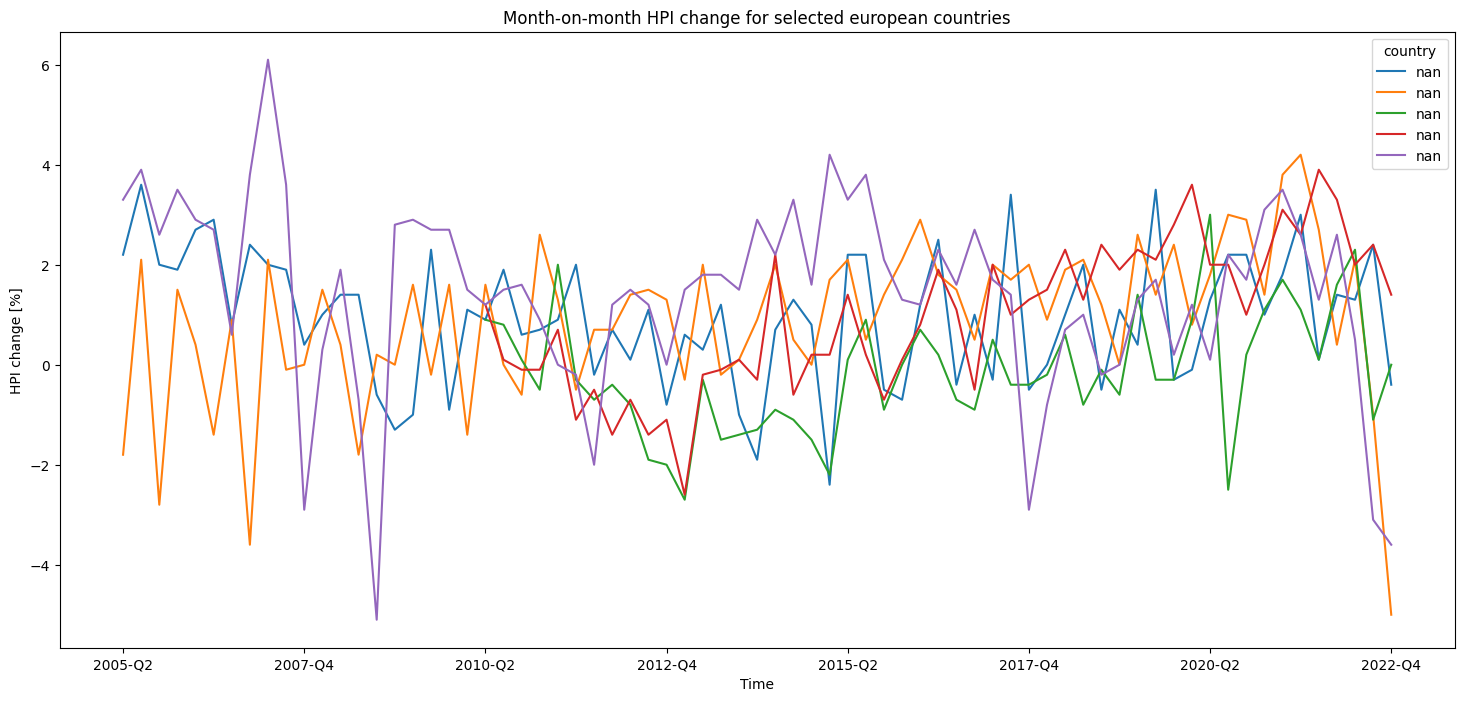

In [7]:
_ = hpi.plot(xlabel='Time', ylabel='HPI change [%]', title='Month-on-month HPI change for selected european countries', figsize=(18, 8), legend=True )

I see the following issues with HPI data loaded above:
1. It's not very granular - quarterly sampling
    * Low observation count per time series
2. Data for **Poland** is missing for a third of the whole time period
    * Will need to either drop data for other countries when not available for **Poland** or backfill for **Poland**

## Gross Domestic Product

One of the most famous metrics for a country is its ***GDP***. Let's visualize it in a similar way (using *eurostat* again):

In [8]:
gdp_raw = ald.get_gdp(config, ['PL', 'DE', 'IT', 'BE', 'SE'])

[INFO] 2023-04-23 23:10:49,196:	 Successfully loaded 'eurostat/NAMQ_10_GDP' from disk.


In [9]:
gdp = gdp_raw.copy()
gdp.head()

country,BE,DE,IT,PL,SE
1975-Q1,NaN,NaN,NaN,NaN,NaN
1975-Q2,NaN,NaN,NaN,NaN,NaN
1975-Q3,NaN,NaN,NaN,NaN,NaN
1975-Q4,NaN,NaN,NaN,NaN,NaN
1976-Q1,NaN,NaN,NaN,NaN,NaN


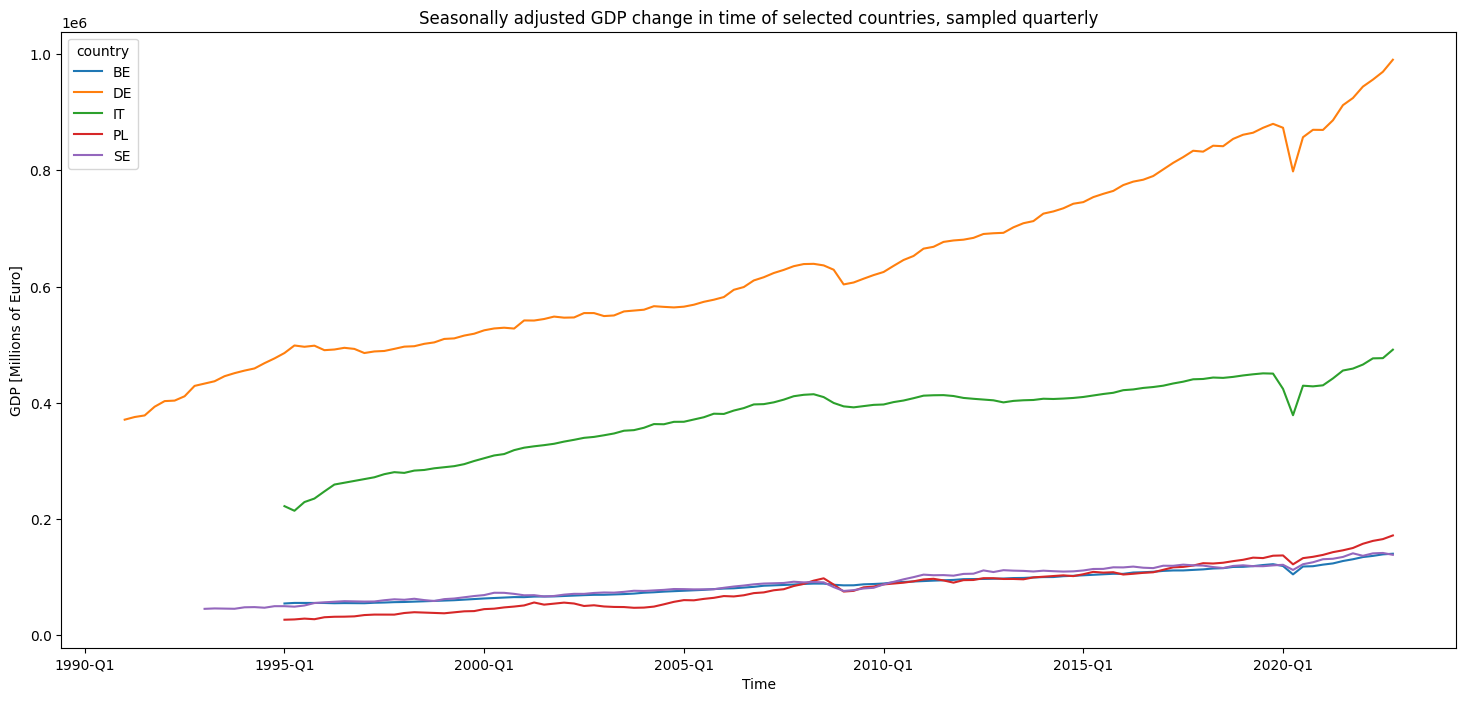

In [10]:
_ = gdp.plot(xlabel='Time', ylabel='GDP [Millions of Euro]', title='Seasonally adjusted GDP change in time of selected countries, sampled quarterly', figsize=(18, 8), legend=True )

Again, some problems with data can be identified:
* This time, starts of time series are even less systematic
* Series look heavily correlated (maybe even ***cointegrated***) which can lead to **false positive results** when looking for causality  